In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def print_sudoku_style(arr):
    GRAY = '\033[90m'
    RESET = '\033[0m'
    n = arr.shape[0]
    block_size = int(math.sqrt(n))

    for i in range(n):
        # Print horizontal block separator
        if i % block_size == 0 and i != 0:
            print('-' * (4 * n + block_size - 8))
        
        row = ''
        for j in range(n):
            # Print vertical block separator
            if j % block_size == 0 and j != 0:
                row += '| '
            
            val = arr[i, j]
            if val == 0:
                row += f'{GRAY} 0{RESET} '
            else:
                row += f'{val:2} '
        print(row)

In [3]:
def initialization(n):
    base = np.zeros((n,n), dtype=int)
    coos = np.array([(0,0,4),(0,2,3),(0,3,5),(0,3,5),(0,4,9),(0,6,7),(0,7,2),(1,1,8),(1,3,6),(1,7,3),(2,0,7),
            (2,2,9),(2,5,4),(2,8,5),(3,0,1),(3,1,5),(3,2,8),(3,4,6),(4,1,7),(4,2,2),(4,6,8),(4,8,9),
            (5,3,2),(5,4,3),(5,5,8),(5,6,5),(5,7,7),(6,1,1),(6,2,5),(6,3,4),(6,8,2),(7,3,8),(7,5,3),(7,6,4),(7,7,5),
            (8,1,3),(8,5,2),(8,7,8),(8,8,7)])
    base[coos[:,0], coos[:,1]] = coos[:,2]
    return base

In [4]:
def extract_groups_vectorized(arr, coords, mode="box", indices=False):
    n = arr.shape[0]
    b = int(math.sqrt(n))
    coords = np.array(coords)

    def get_indices(i, j):
        if mode == "row":
            return np.full(n, i), np.arange(n)
        elif mode == "column":
            return np.arange(n), np.full(n, j)
        elif mode == "box":
            ti, tj = (i // b) * b, (j // b) * b
            di, dj = np.meshgrid(np.arange(b), np.arange(b), indexing='ij')
            return ti + di.ravel(), tj + dj.ravel()
        else:
            raise ValueError("Invalid mode")

    if indices:
        all_entries = [
            np.stack([*(idxs := get_indices(i, j)), arr[idxs]], axis=1)
            for i, j in coords
        ]
        return np.vstack(all_entries)
    else:
        return np.array([arr[get_indices(i, j)] for i, j in coords])

In [5]:
np.printoptions(threshold=np.inf)
base  = initialization(9)
print_sudoku_style(base)
print("\n\n")
# Extracting groups
cos = [(0,0),(4,4)]
row = extract_groups_vectorized(base, cos, mode="row")
print(f"Row 0: {row}\t {type(row)}")
col = extract_groups_vectorized(base, cos, mode="column")
print(f"col 0: {col}\t {type(col)}")
box = extract_groups_vectorized(base, cos, mode="box")
print(f"box 0: {box}\t {type(box)}")


 4  0  3 |  5  9  0 |  7  2  0 
 0  8  0 |  6  0  0 |  0  3  0 
 7  0  9 |  0  0  4 |  0  0  5 
-------------------------------
 1  5  8 |  0  6  0 |  0  0  0 
 0  7  2 |  0  0  0 |  8  0  9 
 0  0  0 |  2  3  8 |  5  7  0 
-------------------------------
 0  1  5 |  4  0  0 |  0  0  2 
 0  0  0 |  8  0  3 |  4  5  0 
 0  3  0 |  0  0  2 |  0  8  7 



Row 0: [[4 0 3 5 9 0 7 2 0]
 [0 7 2 0 0 0 8 0 9]]	 <class 'numpy.ndarray'>
col 0: [[4 0 7 1 0 0 0 0 0]
 [9 0 0 6 0 3 0 0 0]]	 <class 'numpy.ndarray'>
box 0: [[4 0 3 0 8 0 7 0 9]
 [0 6 0 0 0 0 2 3 8]]	 <class 'numpy.ndarray'>


In [6]:
def get_pos(arr, coos):
    """
    arr: the base game array
    coos: the coordinates of the box to be checked in array
    return: the possible numbers that can be put in the box
    """
    n = arr.shape[0]
    Pos= []
    for i in range(coos.shape[0]):
        pos = np.arange(1, n+1)
        if np.all(base[coos[i,0], coos[i,1]]==0):
            box = extract_groups_vectorized(arr, [coos[i]], mode="box")
            row = extract_groups_vectorized(arr, [coos[i]], mode="row")
            col = extract_groups_vectorized(arr, [coos[i]], mode="column")
            pos = np.setdiff1d(pos, box)
            pos = np.setdiff1d(pos, row)
            pos = np.setdiff1d(pos, col)
            Pos.append(pos)
        else:
            print("\033[91mWARNING\033[0m: played box is called. check implementation")
            print(f"\t Already played box at any position in {coos}")
            return base[coos[:,0], coos[:,1]]
    return Pos

In [7]:
coos = np.array([(0,1),(1,0),(4,4)])
get_pos(base, coos)

[array([6]), array([2, 5]), array([1, 4, 5])]

In [8]:
def check_contradiction(base):
    n = base.shape[0]
    all_boxs = np.array([[0,0],[0,3],[0,6],[3,0],[3,3],[3,6],[6,0],[6,3],[6,6]])
    for boxco in all_boxs:
        box = extract_groups_vectorized(base, [boxco], mode="box", indices=True)
        vals = box[:,2]!=0
        filled = box[vals,2]
        xi, yi = box[np.logical_not(vals),0], box[np.logical_not(vals),1]
        poss  = get_pos(base, np.array([xi, yi]).T)
        poss_all = np.unique(np.concatenate(poss))
        to_do = np.setdiff1d(np.arange(1,n+1), filled)
        if not np.array_equal(poss_all, to_do):
            print("\033[91mWARNING\033[0m: contradiction found")
            print(f"\t Missing possible numbers {np.setdiff1d(to_do,poss_all)} in box\n{box[:,2]}")
            return True
        if any(len(a) == 0 for a in poss):
            i =[i for i, a in enumerate(poss) if len(a) == 0][0]
            print("\033[91mWARNING\033[0m: contradiction found")
            print(f"\t No possible numbers at ({xi[i]},{yi[i]}) in box\n{box}")
            return True
    return False

In [9]:
print_sudoku_style(base)

 4  0  3 |  5  9  0 |  7  2  0 
 0  8  0 |  6  0  0 |  0  3  0 
 7  0  9 |  0  0  4 |  0  0  5 
-------------------------------
 1  5  8 |  0  6  0 |  0  0  0 
 0  7  2 |  0  0  0 |  8  0  9 
 0  0  0 |  2  3  8 |  5  7  0 
-------------------------------
 0  1  5 |  4  0  0 |  0  0  2 
 0  0  0 |  8  0  3 |  4  5  0 
 0  3  0 |  0  0  2 |  0  8  7 


In [10]:
check_contradiction(base)

False

In [11]:
a=np.array([4, 0, 3, 0, 8, 5, 7, 0, 9])
np.where(a==0)

(array([1, 3, 7], dtype=int64),)

In [12]:
def get_box_topleft_coords(n):
    if(int(np.sqrt(n))**2 != n):
        raise ValueError("n must be a perfect square")
    b = int(n**0.5)
    starts = np.arange(0, n, b)
    ii, jj = np.meshgrid(starts, starts, indexing='ij')
    return np.stack([ii.ravel(), jj.ravel()], axis=1)



In [13]:
get_box_topleft_coords(9)

array([[0, 0],
       [0, 3],
       [0, 6],
       [3, 0],
       [3, 3],
       [3, 6],
       [6, 0],
       [6, 3],
       [6, 6]])

In [14]:
print_sudoku_style(base)

 4  0  3 |  5  9  0 |  7  2  0 
 0  8  0 |  6  0  0 |  0  3  0 
 7  0  9 |  0  0  4 |  0  0  5 
-------------------------------
 1  5  8 |  0  6  0 |  0  0  0 
 0  7  2 |  0  0  0 |  8  0  9 
 0  0  0 |  2  3  8 |  5  7  0 
-------------------------------
 0  1  5 |  4  0  0 |  0  0  2 
 0  0  0 |  8  0  3 |  4  5  0 
 0  3  0 |  0  0  2 |  0  8  7 


In [15]:
import functions as sudoku

def unique_possibility(base, box):
    # sudoku.print_sudoku_style(base)
    n = base.shape[0]
    box = box[box[:,2] == 0]
    X,Y = box[:,0], box[:,1]
    poss  = get_pos(base, np.array([X, Y]).T)
    poss_all = np.unique(np.concatenate(poss))

    #check if box has only one possible number
    for i in range(len(poss)):
        if len(poss[i]) == 1:
            base[X[i], Y[i]] = poss[i][0]
            print(f"Box unique: {X[i], Y[i]} -> {poss[i][0]}")

    #check if number has only one possible box
    bincount = np.bincount(np.concatenate(poss))
    bincount = np.where(bincount[bincount!=0]==1)[0]
    if len(bincount) != 0:
        val_unique_box = poss_all[bincount]
        for i in val_unique_box:
            for j in range(len(poss)):
                if i in poss[j]:
                    base[X[j], Y[j]] = i
                    print(f"Box unique: {X[j], Y[j]} -> {i}")
                    break
    return base




In [16]:
print_sudoku_style(unique_possibility(base,extract_groups_vectorized(base, [[0,0]], mode="box", indices=True)))

Box unique: (0, 1) -> 6
Box unique: (1, 2) -> 1
Box unique: (1, 2) -> 1
Box unique: (1, 0) -> 5
 4  6  3 |  5  9  0 |  7  2  0 
 5  8  1 |  6  0  0 |  0  3  0 
 7  0  9 |  0  0  4 |  0  0  5 
-------------------------------
 1  5  8 |  0  6  0 |  0  0  0 
 0  7  2 |  0  0  0 |  8  0  9 
 0  0  0 |  2  3  8 |  5  7  0 
-------------------------------
 0  1  5 |  4  0  0 |  0  0  2 
 0  0  0 |  8  0  3 |  4  5  0 
 0  3  0 |  0  0  2 |  0  8  7 


In [17]:
from split_image import split_image

In [35]:
split_image("exampleSudokus/testt2.png",9,9,should_cleanup=False,should_square=False, output_dir="./splits/")

Exporting image tile: ./splits/testt2_0.png
Exporting image tile: ./splits/testt2_1.png
Exporting image tile: ./splits/testt2_2.png
Exporting image tile: ./splits/testt2_3.png
Exporting image tile: ./splits/testt2_4.png
Exporting image tile: ./splits/testt2_5.png
Exporting image tile: ./splits/testt2_6.png
Exporting image tile: ./splits/testt2_7.png
Exporting image tile: ./splits/testt2_8.png
Exporting image tile: ./splits/testt2_9.png
Exporting image tile: ./splits/testt2_10.png
Exporting image tile: ./splits/testt2_11.png
Exporting image tile: ./splits/testt2_12.png
Exporting image tile: ./splits/testt2_13.png
Exporting image tile: ./splits/testt2_14.png
Exporting image tile: ./splits/testt2_15.png
Exporting image tile: ./splits/testt2_16.png
Exporting image tile: ./splits/testt2_17.png
Exporting image tile: ./splits/testt2_18.png
Exporting image tile: ./splits/testt2_19.png
Exporting image tile: ./splits/testt2_20.png
Exporting image tile: ./splits/testt2_21.png
Exporting image tile

In [91]:
from PIL import Image

# Open the image
image = Image.open("./splits/testt2_24.png")

# Convert the image to grayscale. The `"L"` argument in Pillow represents grayscale mode.
grayscale_image = image.convert("L")

# Save the grayscale image
grayscale_image.save("./splits/testt2_24.png")

In [92]:
from CNN import ModelLogger, MNIST_ResNet, show_sample_images,Loader
import torchvision.transforms.v2 as transforms
import torch
import numpy as np
import openml


In [93]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelLogger  = ModelLogger("model_1")
model = MNIST_ResNet(classes=11)
model = modelLogger.load_model(model)

In [94]:
import torch
import matplotlib.pyplot as plt

def plot_tensor_plasma(tensor, title="Tensor Visualization"):
    """
    Plots a torch tensor using the 'plasma' colormap.

    Args:
        tensor (torch.Tensor): 2D or 3D tensor. If 3D, it should be [C, H, W] or [H, W, C].
        title (str): Title of the plot.
    """
    # Detach from graph and move to CPU
    tensor = tensor.detach().cpu()
    
    # If 3D, convert to 2D by taking mean across channels
    if tensor.dim() == 3:
        if tensor.shape[0] <= 4:  # assume shape is [C, H, W]
            tensor = tensor.mean(dim=0)  # average over channels
        else:  # maybe [H, W, C]
            tensor = tensor.mean(dim=2)
    
    # Ensure it's now 2D
    assert tensor.dim() == 2, "Tensor must be 2D or convertible to 2D."

    plt.imshow(tensor.numpy(), cmap='plasma')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()


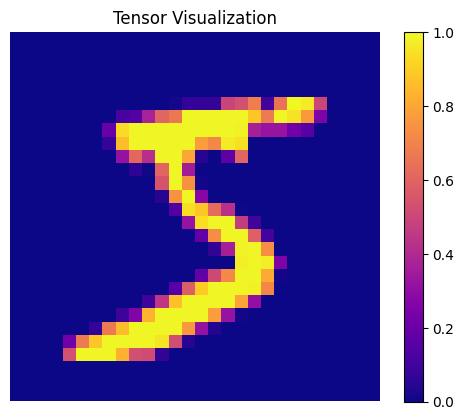

In [95]:
MNIST = openml.datasets.get_dataset(554)
X_all, y_all, categorical_indicator, attribute_names = MNIST.get_data(target=MNIST.default_target_attribute)
X_all = X_all.astype(float)/255.0  # Normalize the dataset to [0, 1]
XX = X_all.iloc[0]
yy = y_all.iloc[0]
XX = torch.tensor(XX.values).reshape(-1, 1, 28, 28)
XX = XX.float()

plot_tensor_plasma(XX.reshape(28,28))

In [96]:
import numpy as np
from PIL import Image

class TrimLowActivity:
    def __init__(self, threshold=0.5, percent=5):
        self.threshold = threshold      # e.g., pixel value threshold (0.5)
        self.percent = percent / 100.0  # e.g., 5% = 0.05

    def __call__(self, img):
        # Convert PIL to NumPy
        img_np = np.array(img).astype(np.float32)

        # Normalize if in 0-255 range
        if img_np.max() > 1:
            img_np /= 255.0

        # Row mask: keep rows where enough pixels > threshold
        row_activity = np.mean(img_np > self.threshold, axis=1)
        valid_rows = row_activity > self.percent

        # Column mask: same for columns
        col_activity = np.mean(img_np > self.threshold, axis=0)
        valid_cols = col_activity > self.percent

        # Trim the image
        trimmed = img_np[np.ix_(valid_rows, valid_cols)]

        # Resize to 28x28 again (or keep as is if preferred)
        trimmed_img = Image.fromarray((trimmed * 255).astype(np.uint8)).resize((28, 28))

        return trimmed_img


In [102]:
from PIL import Image

# Open the image
image = Image.open("./splits/testt2_42.png")

# Convert the image to grayscale. The `"L"` argument in Pillow represents grayscale mode.
grayscale_image = image.convert("L")

# Save the grayscale image
grayscale_image.save("./splits/testt2_42.png")

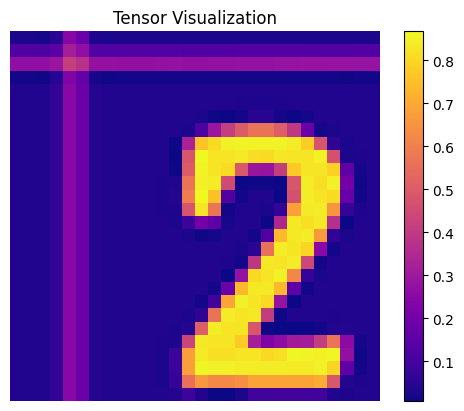

tensor([[-0.4129, -0.2168,  3.4769, -0.9609, -0.7852, -0.4578, -0.6282,  1.9033,
         -0.8343, -0.7805, -0.2685]])
2


In [108]:
transform = transforms.Compose([TrimLowActivity(threshold=0.5, percent=10),transforms.PILToTensor(), transforms.Resize((28,28)), transforms.CenterCrop((28,28))])
X=1-transform(Image.open("./splits/testt2_62.png"))
X = X.unsqueeze(0)/255
plot_tensor_plasma(X.reshape(28,28))
with torch.no_grad():
    model.eval()
    yd = model(X)
    print(yd)
    num = np.argmax(yd)
    print(num.item())

In [73]:
print(X)

tensor([[[[0.1412, 0.2471, 0.2471, 0.2471, 0.2471, 0.2431, 0.1098, 0.0392,
           0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0392,
           0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0392, 0.0392,
           0.0392, 0.0392, 0.0392, 0.0392],
          [0.2706, 0.3529, 0.3529, 0.3529, 0.3529, 0.3451, 0.2431, 0.1843,
           0.1804, 0.1804, 0.1804, 0.1804, 0.1804, 0.1804, 0.1804, 0.1804,
           0.1804, 0.1843, 0.1843, 0.1843, 0.1843, 0.1843, 0.1843, 0.1843,
           0.1843, 0.1843, 0.1843, 0.1843],
          [0.7059, 0.7059, 0.7059, 0.7059, 0.7020, 0.7020, 0.6941, 0.6902,
           0.6902, 0.6902, 0.6941, 0.6941, 0.6941, 0.6941, 0.6941, 0.6980,
           0.6980, 0.6980, 0.6980, 0.6980, 0.6980, 0.6980, 0.7020, 0.7059,
           0.7059, 0.7059, 0.7059, 0.7098],
          [0.7569, 0.7373, 0.7373, 0.7373, 0.7373, 0.7451, 0.7412, 0.7451,
           0.7451, 0.7490, 0.7529, 0.7529, 0.7529, 0.7529, 0.7529, 0.7569,
           0.7608, 0.7608, 0.7608, 0.7608, 

In [1]:
from imageLoader import prepper
import numpy as np
import functions as sudoku



In [2]:
numbers  = np.array(prepper("medium.png",n=9, split_dir="./splits/"))
base = numbers.reshape((9,9))


In [3]:
base

array([[7, 0, 3, 0, 0, 0, 0, 2, 0],
       [8, 0, 0, 0, 0, 2, 7, 0, 0],
       [0, 2, 0, 0, 0, 4, 0, 0, 0],
       [9, 0, 0, 0, 0, 0, 0, 0, 0],
       [5, 0, 0, 0, 8, 0, 0, 3, 0],
       [3, 8, 7, 0, 0, 0, 0, 0, 9],
       [0, 9, 0, 8, 0, 7, 2, 4, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 1, 0, 0, 8, 0]])

In [4]:
boxco = sudoku.get_box_topleft_coords(9)
box = sudoku.extract_groups_vectorized(base, [boxco[3]], mode="box", indices=True)
box = box[box[:,2] == 0]
X,Y = box[:,0], box[:,1]
poss  = sudoku.get_pos(base, np.array([X, Y]).T)
sudoku.get_pos(base, np.array([[0,1],[1,2]]))

[array([1, 4, 5, 6]), array([1, 4, 5, 6, 9])]

In [5]:
poss

[array([1, 4, 6]), array([1, 2, 4, 6]), array([1, 4, 6]), array([1, 2, 4, 6])]

In [6]:
X,Y


(array([3, 3, 4, 4]), array([1, 2, 1, 2]))

In [89]:
base

array([[7, 0, 3, 0, 0, 0, 0, 2, 0],
       [8, 0, 0, 0, 0, 2, 7, 0, 0],
       [0, 2, 0, 0, 0, 4, 0, 0, 0],
       [9, 0, 0, 0, 0, 0, 0, 0, 0],
       [5, 0, 0, 0, 8, 0, 0, 3, 0],
       [3, 8, 7, 0, 0, 0, 0, 0, 9],
       [0, 9, 0, 8, 0, 7, 2, 4, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 1, 0, 0, 8, 0]])

In [90]:
a = np.array([0,1,2,3,4,5,6,7,8,9])
a[np.array([3,5,4])]

array([3, 5, 4])

In [7]:
sudoku.get_pos(base, np.array([[8,2]]), check_line=True)

column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2
column 2 by  [3 4] num:  2


ValueError: setting an array element with a sequence.

In [3]:
base =np.array([
    [4, 6, 3, 5, 9, 1, 7, 2, 8],
    [5, 8, 1, 6, 0, 7, 9, 3, 4],
    [7, 0, 9, 3, 8, 4, 0, 0, 5],
    
    [1, 5, 8, 7, 6, 9, 2, 4, 3],
    [3, 7, 2, 1, 4, 5, 8, 6, 9],
    [0, 0, 0, 2, 3, 8, 5, 7, 1],
    
    [8, 1, 5, 4, 7, 6, 3, 9, 2],
    [0, 0, 7, 8, 1, 3, 4, 5, 6],
    [0, 3, 4, 9, 5, 2, 1, 8, 7],
])


In [2]:
import numpy as np

In [4]:
base

array([[4, 6, 3, 5, 9, 1, 7, 2, 8],
       [5, 8, 1, 6, 0, 7, 9, 3, 4],
       [7, 0, 9, 3, 8, 4, 0, 0, 5],
       [1, 5, 8, 7, 6, 9, 2, 4, 3],
       [3, 7, 2, 1, 4, 5, 8, 6, 9],
       [0, 0, 0, 2, 3, 8, 5, 7, 1],
       [8, 1, 5, 4, 7, 6, 3, 9, 2],
       [0, 0, 7, 8, 1, 3, 4, 5, 6],
       [0, 3, 4, 9, 5, 2, 1, 8, 7]])

In [5]:
from functions import Sudoku

In [6]:
sudoku = Sudoku(base)

In [8]:
sudoku.get_pos([0,0])

AttributeError: 'list' object has no attribute 'shape'

In [10]:
np.array_equal([1,2,3],[1,3,2]) 

False